In [1]:
# dataset = cifar10 
# model = mobilenet 
# optimizer = ADAM (0.001)
# loss = categorical_crossentropy 
# batch_size = 32 
# decay = l2 (0.01)
# augmentation = off

In [2]:
import tensorflow as tf
import os

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Input, Flatten, AveragePooling2D, Add
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist

In [3]:
batch_size=32 
epochs=100
num_classes=10 
depth=20 

In [4]:
model_type = 'MobileNet%d' % (depth)

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
x_train = x_train/255 
x_test = x_test/255 

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes) 
input_shape=x_train.shape[1:]

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
#datagen = ImageDataGenerator(rotation_range=40, horizontal_flip=True, zoom_range=0.1, width_shift_range=0.05, height_shift_range=0.05)
#augmented_data = datagen.flow(x_train, y_train)

In [8]:
def mobilenet(input_size, l2_decay, N_CLASSES):
    """
    Builds the MobileNet model.
    :param tuple input_size: The height and width (in that order) of the
        model input.
    :param float l2_decay: The amount of L2 weight decay to add to the
        loss. Applies only to kernels, not biases.
    :return tensorflow.keras.Sequential: A MobileNet model.
    """

    model = Sequential()

    def _add_bn_relu():
        model.add(BatchNormalization(scale=False))
        model.add(ReLU())

    def _add_depthwise_block(strides=1):
        model.add(DepthwiseConv2D(
            (3, 3),
            strides=strides,
            padding='same',
            kernel_regularizer=l2(l=l2_decay)))
        _add_bn_relu()

    def _add_pointwise_block(filters):
        model.add(Conv2D(filters, (1, 1), kernel_regularizer=l2(l=l2_decay)))
        _add_bn_relu()

    model.add(Conv2D(
        32, (3, 3),
        strides=2,
        padding='same',
        kernel_regularizer=l2(l=l2_decay),
        input_shape=input_size + (3,)))
    _add_bn_relu()
    _add_depthwise_block()
    _add_pointwise_block(64)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(128)
    _add_depthwise_block()
    _add_pointwise_block(128)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(256)
    _add_depthwise_block()
    _add_pointwise_block(256)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(512)
    for _ in range(5):
        _add_depthwise_block()
        _add_pointwise_block(512)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(1024)
    _add_depthwise_block()
    _add_pointwise_block(1024)

    model.add(AveragePooling2D(pool_size=(input_size[0] // 32, input_size[1] // 32)))

    model.add(Flatten())
    model.add(Dense(N_CLASSES, kernel_regularizer=l2(l=l2_decay)))
    model.add(Softmax())

    return model


model = mobilenet(input_size=(32, 32), l2_decay=0.01, N_CLASSES=10)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        96        
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        96        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        2

In [9]:
#model_tf = tf.keras.applications.mobilenet.MobileNet(input_shape=(32, 32, 3), weights=None, classes=10)
#print(model_tf.summary())

In [10]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [11]:
batch_size = 32 
#steps = int(x_train.shape[0]/batch_size) 

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_split=0.1)

Epoch 1/100
1407/1407 - 25s - loss: 13.7179 - accuracy: 0.2643 - val_loss: 4.2264 - val_accuracy: 0.2754
Epoch 2/100
1407/1407 - 16s - loss: 3.0541 - accuracy: 0.3368 - val_loss: 2.5476 - val_accuracy: 0.3152
Epoch 3/100
1407/1407 - 16s - loss: 2.2018 - accuracy: 0.4068 - val_loss: 2.4172 - val_accuracy: 0.3642
Epoch 4/100
1407/1407 - 16s - loss: 2.0078 - accuracy: 0.4614 - val_loss: 2.1524 - val_accuracy: 0.4198
Epoch 5/100
1407/1407 - 16s - loss: 1.8741 - accuracy: 0.5161 - val_loss: 2.8411 - val_accuracy: 0.3180
Epoch 6/100
1407/1407 - 16s - loss: 1.7790 - accuracy: 0.5523 - val_loss: 2.4047 - val_accuracy: 0.4104
Epoch 7/100
1407/1407 - 16s - loss: 1.6888 - accuracy: 0.5832 - val_loss: 2.5139 - val_accuracy: 0.2878
Epoch 8/100
1407/1407 - 16s - loss: 1.6301 - accuracy: 0.6072 - val_loss: 1.9946 - val_accuracy: 0.4796
Epoch 9/100
1407/1407 - 16s - loss: 1.5710 - accuracy: 0.6223 - val_loss: 2.0807 - val_accuracy: 0.4342
Epoch 10/100
1407/1407 - 15s - loss: 1.5285 - accuracy: 0.6329 

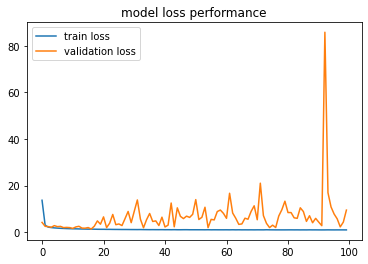

In [12]:
import matplotlib.pyplot as plt 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss performance')
plt.legend(['train loss', 'validation loss'])
plt.show()

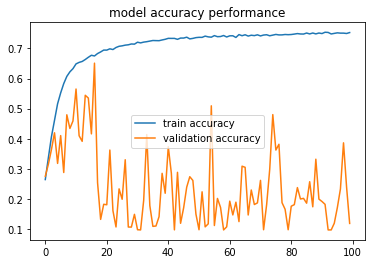

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy performance')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [14]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 9.5286 - accuracy: 0.1104


[9.528633117675781, 0.1103999987244606]